In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor


# Preprocessed Datasets



In [4]:
import joblib

package = joblib.load("tabular_preprocessed.joblib")

X_train = package["X_train_final"]
y_train = package["y_train"]

X_val = package["X_val_final"]
y_val = package["y_val"]

X_test = package["X_test_final"]

feature_names = package["feature_names"]
scaler = package["scaler"]

train_ids = package["train_ids"]
val_ids = package["val_ids"]
test_ids = package["test_ids"]


In [5]:
import json
with open("train_config.json") as f:
    cfg = json.load(f)


# Baseline model training

In [ ]:
X_train.shape

(12967, 23)

In [ ]:
from sklearn.metrics import root_mean_squared_error, r2_score

def evaluate(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"Validation RMSE: {rmse:.4f}")
    print(f"Validation R² : {r2:.4f}")
    return rmse, r2

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
val_preds = model.predict(X_val)

rmse, r2 = evaluate(y_val, val_preds)

Validation RMSE: 0.2424
Validation R² : 0.7870


In [ ]:
from sklearn.ensemble import RandomForestRegressor
model_Rdforest = RandomForestRegressor()
model_Rdforest.fit(X_train, y_train)



RandomForestRegressor()

In [ ]:
val_preds = model_Rdforest.predict(X_val)

rmse, r2 = evaluate(y_val, val_preds)

Validation RMSE: 0.1800
Validation R² : 0.8826


In [ ]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

model_xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
val_preds = model_xgb.predict(X_val)

rmse, r2 = evaluate(y_val, val_preds)

Validation RMSE: 0.1671
Validation R² : 0.8989


# MultimodalRegressor

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import Image
import os

class MultimodalDataset(Dataset):
    def __init__(self, image_dir, tabular_data, ids, targets=None, transform=None):
        self.image_dir = image_dir
        self.tabular_data = tabular_data
        self.ids = ids
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        sample_id = self.ids[idx]
        img_path = os.path.join(self.image_dir, f"{sample_id}.png")

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        tabular = torch.tensor(self.tabular_data[idx], dtype=torch.float32)

        if self.targets is not None:
            target = torch.tensor(self.targets[idx], dtype=torch.float32)
            return image, tabular, target

        return image, tabular


class TabularEncoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)


class MultimodalRegressor(nn.Module):
    def __init__(self, image_encoder, tabular_dim):
        super().__init__()

        self.image_encoder = image_encoder

        self.regressor = nn.Sequential(
            nn.Linear(512 + tabular_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),

            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),

            nn.Linear(128, 1)
        )

    def forward(self, image, tabular):
        img_feat = self.image_encoder(image)
        x = torch.cat([img_feat, tabular], dim=1)
        return self.regressor(x)



In [7]:
from torchvision import transforms
val_img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [8]:
TRAIN_DIR = "map_images/train"
TEST_DIR = "map_images/test"

from torchvision import transforms

train_img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
val_img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [9]:
from torchvision import transforms
from torch.utils.data import DataLoader

train_dataset = MultimodalDataset(
    image_dir=cfg["train_image_dir"],
    tabular_data=X_train,
    ids=train_ids,
    targets=y_train,
    transform=train_img_transform
)

val_dataset = MultimodalDataset(
    image_dir=cfg["train_image_dir"],
    tabular_data=X_val,
    ids=val_ids,
    targets=y_val,
    transform=val_img_transform
)

test_dataset = MultimodalDataset(
    image_dir=cfg["test_image_dir"],
    tabular_data=X_test,
    ids=test_ids,
    transform=val_img_transform
)

train_loader = DataLoader(train_dataset, batch_size=cfg["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=cfg["batch_size"], shuffle=False)

In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = 2

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)



# CNN + Xgboost


In [65]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score



In [66]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Identity()
resnet.eval().to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [67]:
def extract_image_features(model, loader, device):
    model.eval()
    features = []
    targets = []
    tabular_features = []

    with torch.no_grad():
        for images, tabular, y in loader:
            images = images.to(device)

            img_features = model(images)
            features.append(img_features.cpu().numpy())

            tabular_features.append(tabular.numpy())
            targets.append(y.numpy())

    X_img = np.vstack(features)
    X_tab = np.vstack(tabular_features)
    y = np.concatenate(targets)

    return X_img, X_tab, y


In [68]:
X_img_train, X_tab_train, y_train = extract_image_features(
    resnet, train_loader, device
)

X_img_val, X_tab_val, y_val = extract_image_features(
    resnet, val_loader, device
)


In [69]:
X_train = np.hstack([X_img_train, X_tab_train])
X_val   = np.hstack([X_img_val, X_tab_val])


In [70]:
xgb_model = xgb.XGBRegressor(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)


In [71]:
xgb_model.fit(
    X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=-1, num_parallel_tree=None, ...)

In [74]:
y_pred_log = xgb_model.predict(X_val)

y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_val)
rmse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("RMSE:", rmse)
print("R²:", r2)


RMSE: 15738407936.0
R²: 0.8745830059051514


# Test dataset prediction

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import Image
import os
from torchvision import transforms



In [12]:
import torch
import torch.nn as nn
from torchvision import models


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [16]:
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Identity()


In [15]:
NUM_TABULAR_FEATURES = 23

model = MultimodalRegressor(
    image_encoder=resnet,
    tabular_dim=NUM_TABULAR_FEATURES
).to(device)


In [17]:
model = MultimodalRegressor(
    image_encoder=resnet,
    tabular_dim=23
)

model.load_state_dict(
    torch.load("best_multimodal_model.pt", map_location=device)
)

model = model.to(device)
model.eval()


MultimodalRegressor(
  (image_encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [ ]:
test_preds = []

with torch.no_grad():
    for images, tabular in test_loader:
        images = images.to(device)
        tabular = tabular.to(device)

        outputs = model(images, tabular).squeeze(1)
        test_preds.extend(outputs.cpu().numpy())


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
test_prices = np.expm1(test_preds)


In [ ]:
import joblib

package = joblib.load("tabular_preprocessed.joblib")
test_ids = package["test_ids"]

submission = pd.DataFrame({
    "id": test_ids,
    "predicted_price": test_prices
})

submission.to_csv("outputs/final_predictions.csv", index=False)


# GRAD-CAM Heatmap and Overlays

In [19]:
df = pd.read_csv("outputs/final_predictions.csv")

In [20]:
df = df.sort_values("predicted_price").reset_index(drop=True)

In [21]:
test_tabular_dict = {
    int(id_): X_test[i]
    for i, id_ in enumerate(test_ids)
}


In [55]:
BOTTOM_5 = df.head(2)
TOP_5 = df.tail(2)
MEDIUM_5 = df.iloc[
    len(df)//2 - 2 : len(df)//2 + 3]


In [48]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


target_layer = model.image_encoder.layer4[-1]
gradcam = GradCAM(model=model, target_layers=[target_layer])

In [49]:
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

    img = img_tensor.cpu() * std + mean
    img = img.permute(1,2,0).numpy()
    img = np.clip(img, 0, 1)
    return img

In [50]:
import cv2
import numpy as np

def overlay_cam(image, cam, alpha=0.35):

    cam = cv2.resize(cam, (image.shape[1], image.shape[0]))

    # Normalize
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)

    heatmap = cv2.applyColorMap(
        np.uint8(255 * cam),
        cv2.COLORMAP_TURBO

    )
    heatmap = heatmap[..., ::-1] / 255.0

    overlay = (1 - alpha) * image + alpha * heatmap
    overlay = np.clip(overlay, 0, 1)

    return overlay

In [51]:
def generate_cam_panel(df_subset, title, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    for _, row in df_subset.iterrows():
        sample_id = int(row["id"])


        img_path = None
        for folder in ["map_images/test", "map_images/train"]:
            p = f"{folder}/{sample_id}.png"
            if os.path.exists(p):
                img_path = p
                break

        if img_path is None:
            print(f"Skipping ID {sample_id} (image not found)")
            continue

        # image
        image = Image.open(img_path).convert("RGB")
        image_tensor = val_img_transform(image).unsqueeze(0).to(device)

        # tabular
        tabular = torch.tensor(
            test_tabular_dict[sample_id],
            dtype=torch.float32
        ).unsqueeze(0).to(device)

        # forward method
        original_forward = model.forward

        # tabular data as a fixed input
        def wrapped_forward(image_input):
            return original_forward(image_input, tabular)

        model.forward = wrapped_forward

        cam = gradcam(input_tensor=image_tensor, targets=None)[0]

        model.forward = original_forward

        # Visuals
        orig = denormalize(image_tensor[0])
        overlay = overlay_cam(orig, cam)


        # Plot
        fig, axes = plt.subplots(1, 3, figsize=(12,4))
        axes[0].imshow(orig)
        axes[0].set_title("Original Satelite Image")

        axes[1].imshow(cam, cmap="jet")
        axes[1].set_title("Grad-CAM Heatmap ")

        axes[2].imshow(overlay)
        axes[2].set_title("Grad-CAM Overlay")

        for ax in axes:
            ax.axis("off")

        # plt.suptitle(f"{title} | ID {sample_id}")
        plt.tight_layout()
        plt.savefig(f"{save_dir}/{sample_id}.png")
        plt.close()

In [52]:
generate_cam_panel(
    TOP_5,
    title="Top 2 High-Value Properties",
    save_dir="outputs/gradcam/top_2"
)

generate_cam_panel(
    MEDIUM_5,
    title="Medium 2 Properties",
    save_dir="outputs/gradcam/medium_2"
)

generate_cam_panel(
    BOTTOM_5,
    title="Bottom 2 Low-Value Properties",
    save_dir="outputs/gradcam/bottom_2"
)


In [58]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def plot_images_one_per_row(image_dir, figsize_per_image=(12, 4)):
    image_files = sorted([
        f for f in os.listdir(image_dir)
        if f.lower().endswith((".png"))
    ])

    n = len(image_files)
    if n == 0:
        print("No images found.")
        return

    fig, axes = plt.subplots(
        nrows=n,
        ncols=1,
        figsize=(figsize_per_image[0], figsize_per_image[1] * n)
    )


    if n == 1:
        axes = [axes]

    for ax, img_name in zip(axes, image_files):
        img_path = os.path.join(image_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        ax.imshow(img)

        ax.axis("off")

    plt.tight_layout()
    plt.show()


# High value Properties Imagery data

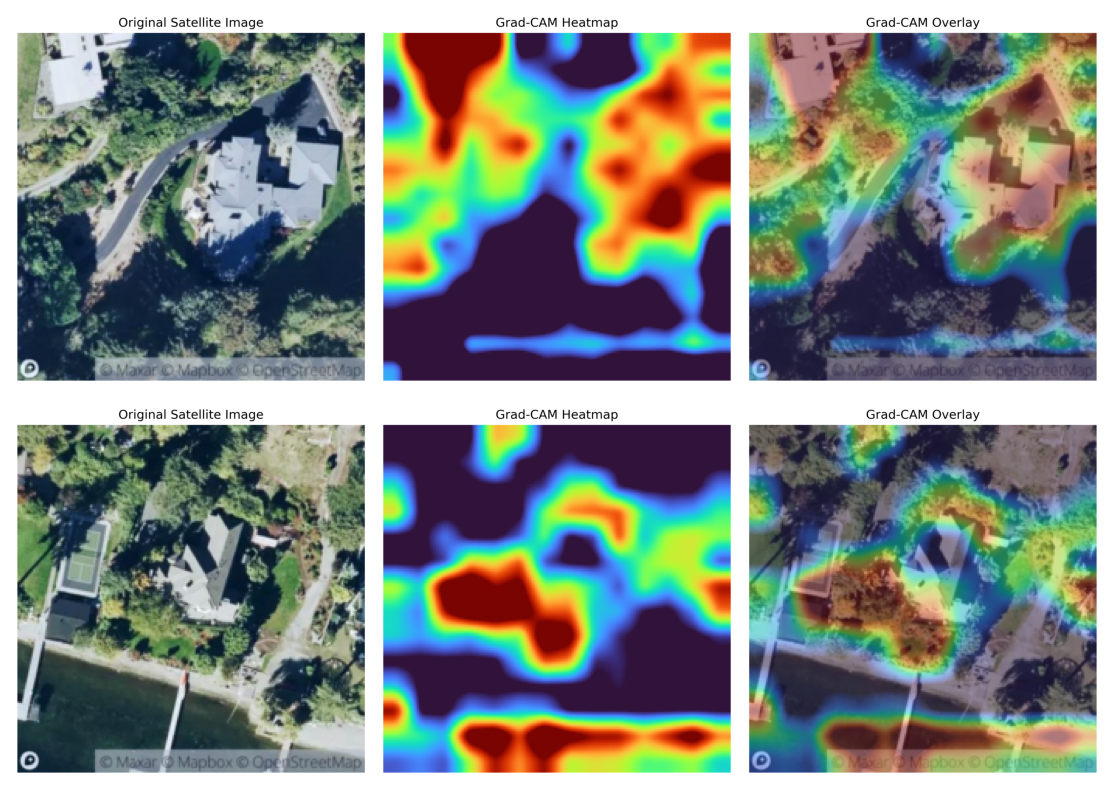

In [60]:
plot_images_one_per_row('outputs/gradcam/top_2')

# Lowest_value Properties Imagery data

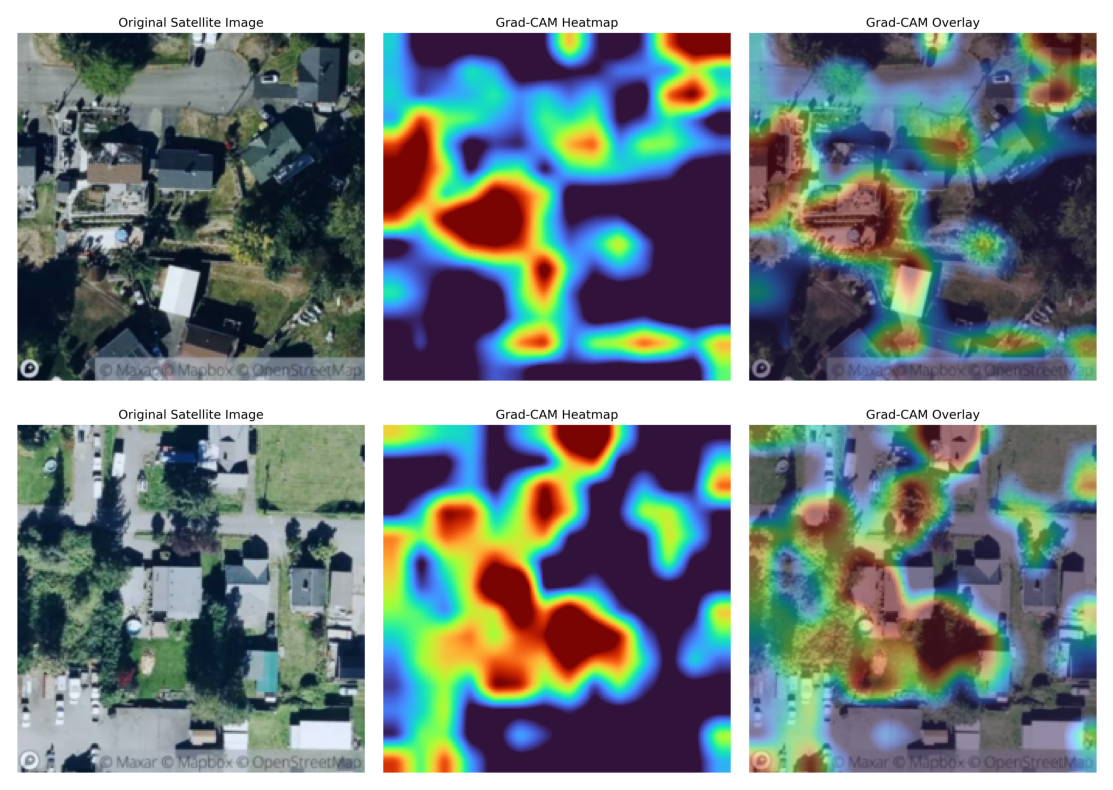

In [63]:
plot_images_one_per_row('outputs/gradcam/bottom_2')

# Medium value Properties Imagery data

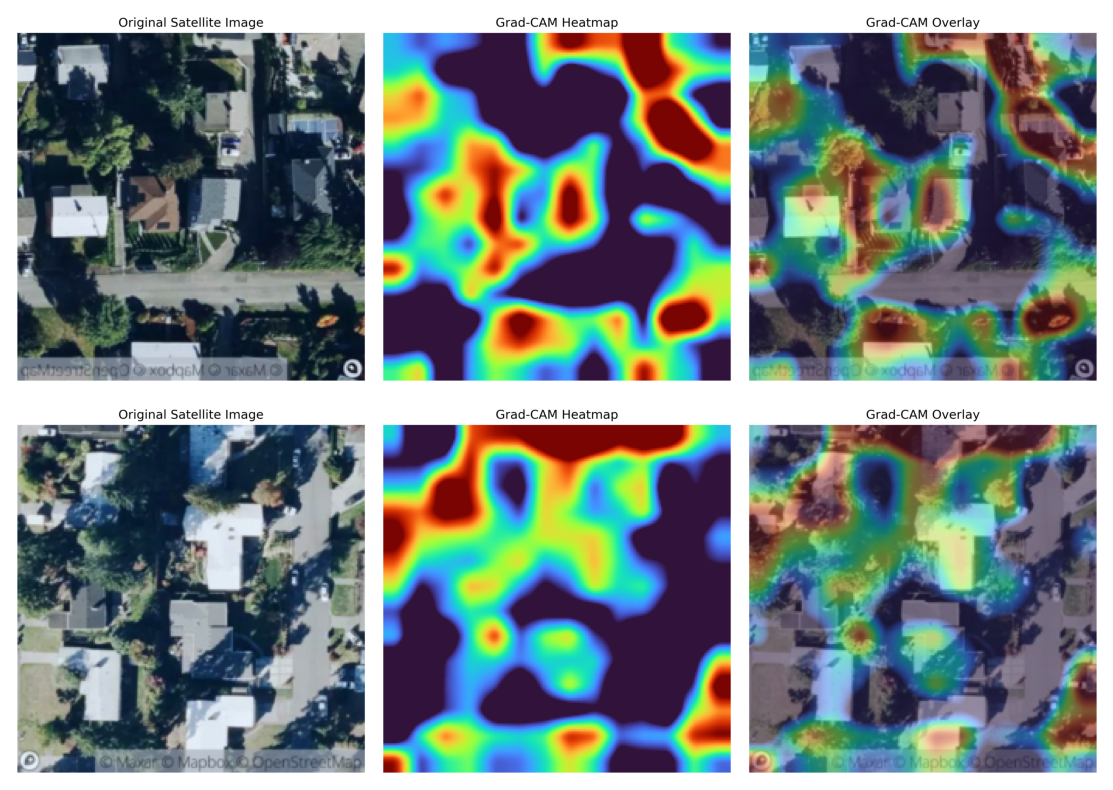

In [64]:
plot_images_one_per_row('outputs/gradcam/medium_2')